# SVM with Optuna Hyperparameter Tuning


In [7]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Configuration
c = Path.cwd()
repo_root = None
for _ in range(5):
    if (c / 'ML').exists() and (c / 'ML').is_dir():
        repo_root = c
        break
    if c.parent == c:
        break
    c = c.parent
if repo_root is None:
    repo_root = Path.cwd().parent if Path.cwd().name == 'ML' else Path.cwd()
OUTPUT_DIR = (repo_root / 'ML' / 'outputs' / '01_SVM').resolve()
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print(f'OUTPUT_DIR: {OUTPUT_DIR}')

LIGHT_CM = LinearSegmentedColormap.from_list('white_to_lightblue', ['#ffffff', '#e6f0ff', '#cfe0ff'])
N_TRIALS = 50

OUTPUT_DIR: /home/maroco/SKN19-mini-1Team/ML/outputs/01_SVM


In [ ]:
DATA_PATH = '../data/training/final/travel_insight_pruned.csv'
travel = pd.read_csv(DATA_PATH)
print(f'Data loaded: {DATA_PATH}')

Data loaded: ../data/training/final/travel_insight_pruned.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5759 entries, 0 to 5758
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   TRAVEL_ID                      5759 non-null   object 
 1   TRAVEL_LENGTH                  5759 non-null   int64  
 2   activity_payment_sum           5759 non-null   float64
 3   visit_move_cnt                 5759 non-null   int64  
 4   IS_FAILED_TRIP                 5759 non-null   int64  
 5   TRAVEL_SEASON                  5759 non-null   object 
 6   TRAVEL_SEASON_encoded          5759 non-null   int64  
 7   activity_type_1                5759 non-null   int64  
 8   activity_type_2                5759 non-null   int64  
 9   activity_type_3                5759 non-null   int64  
 10  activity_type_4                5759 non-null   int64  
 11  activity_type_5                5759 non-null  

In [9]:
# 학습에 사용할 피처값 선언
BINARY_CLASSIFICATION_TARGET = 'IS_FAILED_TRIP'

BINARY_CLASSIFICATION_FEATURES = [
    'TRAVEL_LENGTH',
    'activity_payment_sum',
    'visit_move_cnt',
    # 'TRAVEL_SEASON',
    'TRAVEL_SEASON_encoded',
    'activity_type_1',
    'activity_type_2',
    'activity_type_3',
    'activity_type_4',
    'activity_type_5',
    'activity_type_6',
    'activity_type_7',
    'activity_type_99',
    'activity_history_rows',
    # 'activity_type_catboost',
    'visit_move_cnt_per_day',
    'activity_payment_sum_per_day',
    'activity_type_1_per_day',
    'activity_type_2_per_day',
    'activity_type_3_per_day',
    'activity_type_4_per_day',
    'activity_type_5_per_day',
    'activity_type_6_per_day',
    'activity_type_7_per_day',
    'activity_type_99_per_day',
    'activity_history_rows_per_day'
]

In [10]:
X = travel[BINARY_CLASSIFICATION_FEATURES]
y = travel[BINARY_CLASSIFICATION_TARGET]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [12]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

def objective(trial):
    # Define hyperparameter search space
    c_param = trial.suggest_float('C', 1e-2, 1e2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = 'scale'
    if kernel == 'rbf':
        gamma = trial.suggest_float('gamma', 1e-3, 1, log=True)

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', SVC(C=c_param, kernel=kernel, gamma=gamma, probability=True, random_state=42, class_weight='balanced'))])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict_proba(X_val_fold)[:, 1]
        pr_auc = average_precision_score(y_val_fold, preds)
        scores.append(pr_auc)

    return np.mean(scores)

print("Starting hyperparameter optimization with Optuna for SVM...")
study = optuna.create_study(direction='maximize', study_name='svm_optimization')
study.optimize(objective, n_trials=N_TRIALS)

print("Optimization finished.")
print('Best trial:')
best_trial = study.best_trial
print(f'  Value (PR-AUC): {best_trial.value:.4f}')
print('  Best Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

print("Training the best model on the full training data...")
best_params = best_trial.params
best_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', SVC(**best_params, probability=True, random_state=42, class_weight='balanced'))])
best_model_pipeline.fit(X_train, y_train)
print("Best model trained successfully.")

[I 2025-09-27 23:33:22,741] A new study created in memory with name: svm_optimization


Starting hyperparameter optimization with Optuna for SVM...


[I 2025-09-27 23:33:26,915] Trial 0 finished with value: 0.27116379323456535 and parameters: {'C': 0.016603539938851386, 'kernel': 'rbf', 'gamma': 0.2796427156665332}. Best is trial 0 with value: 0.27116379323456535.
[I 2025-09-27 23:33:32,763] Trial 1 finished with value: 0.32463610629255174 and parameters: {'C': 2.415654959269808, 'kernel': 'linear'}. Best is trial 1 with value: 0.32463610629255174.
[I 2025-09-27 23:33:36,963] Trial 2 finished with value: 0.29956713646526456 and parameters: {'C': 0.02819995523569909, 'kernel': 'rbf', 'gamma': 0.04542885560528387}. Best is trial 1 with value: 0.32463610629255174.
[I 2025-09-27 23:34:04,831] Trial 3 finished with value: 0.3249875056623065 and parameters: {'C': 27.190344687083424, 'kernel': 'linear'}. Best is trial 3 with value: 0.3249875056623065.
[I 2025-09-27 23:34:07,677] Trial 4 finished with value: 0.32169167279894334 and parameters: {'C': 0.024992911200551502, 'kernel': 'linear'}. Best is trial 3 with value: 0.3249875056623065.
[

Optimization finished.
Best trial:
  Value (PR-AUC): 0.3251
  Best Params: 
    C: 6.44277230707402
    kernel: linear
Training the best model on the full training data...
Best model trained successfully.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score

y_proba_train = best_model_pipeline.predict_proba(X_train)[:,1]
y_proba_test = best_model_pipeline.predict_proba(X_test)[:,1]
y_pred_train = best_model_pipeline.predict(X_train)
y_pred_test = best_model_pipeline.predict(X_test)

print('='*5+'Train (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_train, y_pred_train):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))
print(f'ROC-AUC : {roc_auc_score(y_train, y_proba_train):.4f}')
print(f'PR-AUC  : {average_precision_score(y_train, y_proba_train):.4f}')

print('='*5+'Test (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_test, y_pred_test):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print(f'ROC-AUC : {roc_auc_score(y_test, y_proba_test):.4f}')
print(f'PR-AUC  : {average_precision_score(y_test, y_proba_test):.4f}')

fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax, cmap=LIGHT_CM)
ax.set_title('Confusion Matrix (SVM)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.close(fig)

=====Train (BestModel)======================================================================
Acc : 0.4914
Confusion Matrix
[[1185 1685]
 [ 365  796]]
              precision    recall  f1-score   support

           0       0.76      0.41      0.54      2870
           1       0.32      0.69      0.44      1161

    accuracy                           0.49      4031
   macro avg       0.54      0.55      0.49      4031
weighted avg       0.64      0.49      0.51      4031

ROC-AUC : 0.5728
PR-AUC  : 0.3335
=====Test (BestModel)======================================================================
Acc : 0.4751
Confusion Matrix
[[518 712]
 [195 303]]
              precision    recall  f1-score   support

           0       0.73      0.42      0.53      1230
           1       0.30      0.61      0.40       498

    accuracy                           0.48      1728
   macro avg       0.51      0.51      0.47      1728
weighted avg       0.60      0.48      0.49      1728

ROC-AUC : 0.5317


In [14]:
y_pred_test_series = pd.Series(y_pred_test, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test, index=X_test.index, name='predicted_proba')
tp_mask = (y_test == 1) & (y_pred_test_series == 1)
tp_df = X_test.loc[tp_mask].copy()
tp_df['actual'] = y_test.loc[tp_mask]
tp_df['predicted'] = y_pred_test_series.loc[tp_mask]
tp_df['predicted_proba'] = y_proba_test_series.loc[tp_mask]
print(f'Total true positives in test set: {tp_df.shape[0]}')
tp_out = os.path.join(OUTPUT_DIR, 'TP_traveler_svm.csv')
tp_df.to_csv(tp_out, index=False)
print(f'Saved: {tp_out}')

Total true positives in test set: 303
Saved: /home/maroco/SKN19-mini-1Team/ML/outputs/01_SVM/TP_traveler_svm.csv


In [15]:
y_pred_test_series = pd.Series(y_pred_test, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test, index=X_test.index, name='predicted_proba')
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true negatives in test set: {tn_df.shape[0]}')
tn_out = os.path.join(OUTPUT_DIR, 'TN_traveler_svm.csv')
tn_df.to_csv(tn_out, index=False)
print(f'Saved: {tn_out}')

Total true negatives in test set: 518
Saved: /home/maroco/SKN19-mini-1Team/ML/outputs/01_SVM/TN_traveler_svm.csv


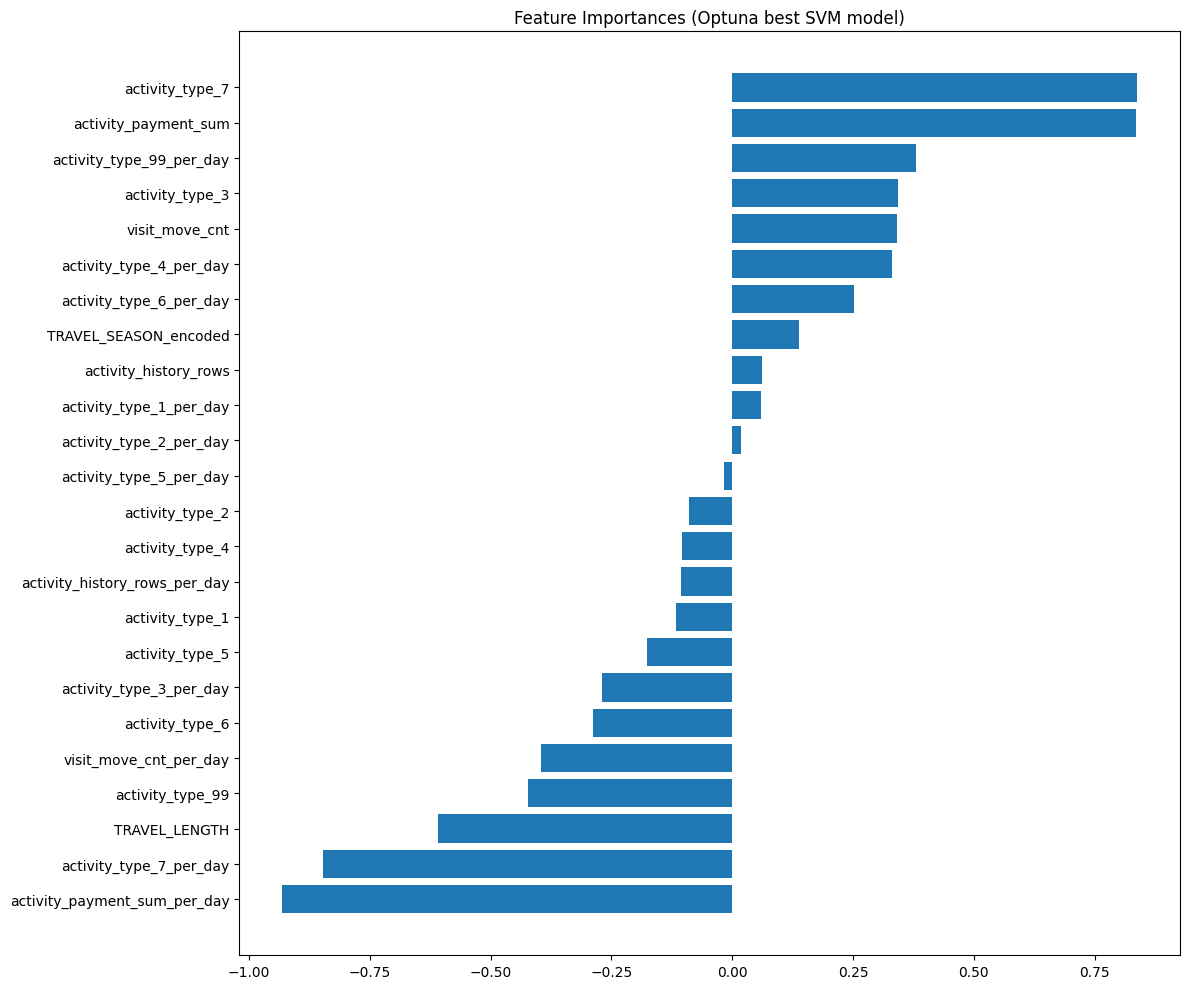

Feature Importances:
activity_type_7                  0.838062
activity_payment_sum             0.835501
activity_type_99_per_day         0.379601
activity_type_3                  0.343581
visit_move_cnt                   0.341314
activity_type_4_per_day          0.331565
activity_type_6_per_day          0.251120
TRAVEL_SEASON_encoded            0.137257
activity_history_rows            0.061556
activity_type_1_per_day          0.059900
activity_type_2_per_day          0.018531
activity_type_5_per_day         -0.017729
activity_type_2                 -0.089834
activity_type_4                 -0.103269
activity_history_rows_per_day   -0.105468
activity_type_1                 -0.117179
activity_type_5                 -0.175661
activity_type_3_per_day         -0.268675
activity_type_6                 -0.288329
visit_move_cnt_per_day          -0.395399
activity_type_99                -0.421844
TRAVEL_LENGTH                   -0.608917
activity_type_7_per_day         -0.847505
activity_paym

In [19]:
# 특성 중요도 (베스트 모델)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The best model from Optuna was a linear SVM, so we can get feature importances from the coefficients.
if best_trial.params['kernel'] == 'linear':
    classifier = best_model_pipeline.named_steps['classifier']
    importances = classifier.coef_[0]
    
    feature_names = X_train.columns
    feat_imp_ser = pd.Series(importances, index=feature_names)
    
    # Use absolute values for magnitude of importance
    abs_feat_imp = np.abs(feat_imp_ser)
    sorted_feat_imp = abs_feat_imp.sort_values()
    
    plt.figure(figsize=(12, 10))
    plt.barh(sorted_feat_imp.index, sorted_feat_imp.values)
    plt.title('Feature Importance for Predicting Trip Failure')
    plt.xlabel('Importance (Magnitude)')
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, 'feature_importances_top.png')
    plt.savefig(out_path)
    plt.show()
    
    # Print sorted importances
    print("Feature Importances (by magnitude):")
    print(feat_imp_ser.abs().sort_values(ascending=False))
else:
    print("Feature importance is only available for linear kernels.")
    print(f"The best model has a '{best_trial.params['kernel']}' kernel.")